In [62]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [63]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [64]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [65]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [66]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)
LogisticRegression()

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [67]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

In [68]:
from sklearn.metrics import accuracy_score

In [69]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [70]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.737
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


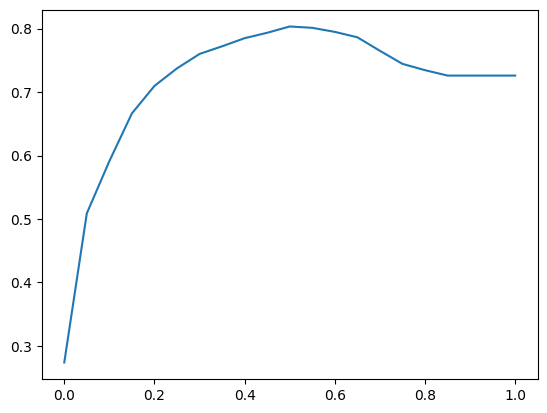

In [71]:
plt.plot(thresholds, scores)

In [72]:
from collections import Counter

In [73]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [74]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [75]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [76]:
t=0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [77]:
true_positive = (predict_positive & actual_positive).sum()
true_negative = (predict_negative & actual_negative).sum()

In [78]:
false_positive = (predict_positive & actual_negative).sum()
false_negative = (predict_negative & actual_positive).sum()

In [79]:
confusion_matrix = np.array([
    [true_negative, false_positive],
    [false_negative, true_positive]
]
)

In [80]:
print(confusion_matrix)

[[922 101]
 [176 210]]


In [81]:
confusion_matrix / confusion_matrix.sum()

array([[0.6543648 , 0.07168204],
       [0.12491128, 0.14904187]])

In [82]:
precision = true_positive / (true_positive + false_positive)
precision

0.6752411575562701

In [83]:
recall = true_positive / (true_positive + false_negative)
recall

0.5440414507772021

In [84]:
tpr=true_positive/(true_positive+false_negative)

In [85]:
fpr=false_positive/(false_positive+true_negative)

In [86]:
tpr, fpr

(0.5440414507772021, 0.09872922776148582)

In [87]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [88]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

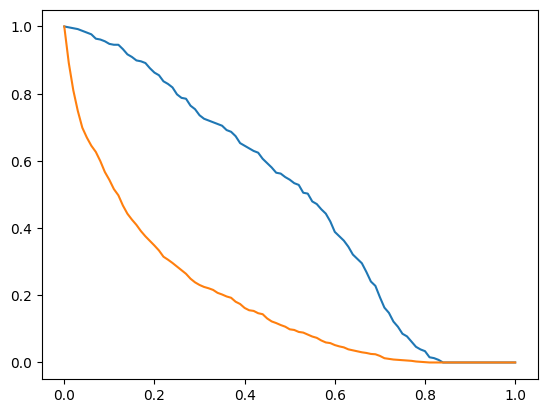

In [89]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

In [90]:
np.random.seed(1)
y_rand=np.random.uniform(0,1,size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [91]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [92]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [93]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [94]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [95]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [96]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


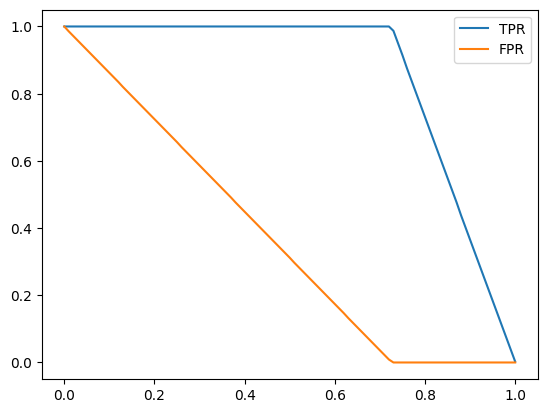

In [97]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

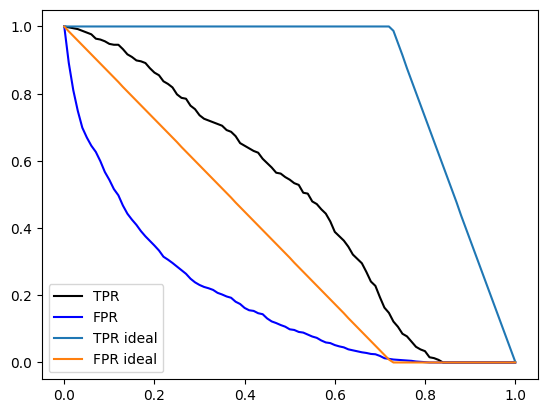

In [98]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

In [99]:
from sklearn.metrics import roc_curve

In [100]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

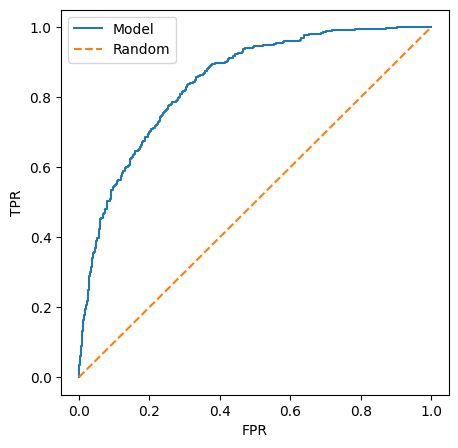

In [101]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [102]:
from sklearn.metrics import auc

In [103]:
auc(fpr, tpr)

0.8438682327199793

In [104]:
auc(df_scores.fpr, df_scores.tpr)

0.8437770653214409

In [105]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [106]:
from sklearn.metrics import roc_auc_score

In [107]:
roc_auc_score(y_val, y_pred)

0.8438682327199793

In [108]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [109]:
import random

In [110]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84163

In [111]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84654

In [112]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [113]:
dv, model = train(df_train, y_train, C=0.001)

In [114]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [115]:
y_pred = predict(df_val, dv, model)

In [116]:
y_pred

array([0.02500124, 0.23985224, 0.24631874, ..., 0.2468139 , 0.75558332,
       0.75894002])

In [117]:
from sklearn.model_selection import KFold

In [118]:
from tqdm.auto import tqdm

In [119]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [120]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:01<00:08,  1.38s/it]

C=0.001 0.825 +- 0.009


 29%|██▊       | 2/7 [00:03<00:10,  2.10s/it]

C=0.01 0.840 +- 0.008


 43%|████▎     | 3/7 [00:07<00:11,  2.87s/it]

C=0.1 0.842 +- 0.007


 57%|█████▋    | 4/7 [00:10<00:08,  2.73s/it]

C=0.5 0.842 +- 0.007


 71%|███████▏  | 5/7 [00:12<00:05,  2.65s/it]

C=1 0.842 +- 0.007


 86%|████████▌ | 6/7 [00:15<00:02,  2.63s/it]

C=5 0.842 +- 0.007


100%|██████████| 7/7 [00:18<00:00,  2.60s/it]

C=10 0.842 +- 0.007


In [121]:
scores

[0.8446789804617281,
 0.8451591676599126,
 0.8333774834437087,
 0.8347888821385174,
 0.851738257349942]

In [122]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8583788336745859